# Extensive Exploratory Data Analysis (EDA)

This notebook performs a detailed analysis of the French Cards dataset, including:
- Dataset structure and integrity checks
- Class distribution analysis
- Bounding box analysis (sizes, aspect ratios, locations)
- Image content analysis (resolutions, pixel intensities)
- Visual inspection of samples

In [1]:
import os
import glob
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Load Dataset Configuration

In [2]:
DATA_YAML = "data.yaml"

with open(DATA_YAML, 'r') as f:
    data_config = yaml.safe_load(f)

print("Dataset Path:", data_config['path'])
print("Train Dir:", data_config['train'])
print("Val Dir:", data_config['val'])
print("Number of Classes:", data_config['nc'])
print("Class Names:", data_config['names'])

Dataset Path: /Users/crescenzodepalma/Projects/cdpcre/french_cards_detector_pytorch/datasets/unified
Train Dir: images/train
Val Dir: images/val
Number of Classes: 53
Class Names: ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs', 'joker']


## 2. Data Loading and Parsing
We will scan the training directory to load image paths and parse label files.

In [3]:
def get_image_label_paths(root_dir, split_rel_path):
    # Construct absolute path to images
    # data_config['path'] is absolute, split_rel_path is relative (e.g. images/train)
    img_dir = os.path.join(root_dir, split_rel_path)
    
    # Assume labels are in a parallel 'labels' directory
    # e.g. images/train -> labels/train
    lbl_dir = img_dir.replace("images", "labels")
    
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.*")))
    # Filter for valid image extensions if needed, but glob *.* is usually fine for first pass
    img_paths = [p for p in img_paths if p.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    data = []
    for img_path in tqdm(img_paths, desc=f"Loading {split_rel_path}"):
        basename = os.path.basename(img_path)
        name_no_ext = os.path.splitext(basename)[0]
        lbl_path = os.path.join(lbl_dir, name_no_ext + ".txt")
        
        if os.path.exists(lbl_path):
            with open(lbl_path, 'r') as f:
                lines = f.readlines()
            
            # Parse YOLO format: class x_center y_center width height
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls_id = int(parts[0])
                    x_c, y_c, w, h = map(float, parts[1:])
                    data.append({
                        'image_path': img_path,
                        'label_path': lbl_path,
                        'class_id': cls_id,
                        'class_name': data_config['names'][cls_id],
                        'x_center': x_c,
                        'y_center': y_c,
                        'width': w,
                        'height': h,
                        'split': split_rel_path
                    })
        else:
             # Image with no label (background or missing)
             data.append({
                'image_path': img_path,
                'label_path': None,
                'class_id': -1,
                'class_name': 'background',
                'x_center': np.nan,
                'y_center': np.nan,
                'width': np.nan,
                'height': np.nan,
                'split': split_rel_path
            })
            
    return pd.DataFrame(data)

root_path = data_config['path']
df_train = get_image_label_paths(root_path, data_config['train'])
df_val = get_image_label_paths(root_path, data_config['val'])

df = pd.concat([df_train, df_val], ignore_index=True)
print(f"Total annotations: {len(df)}")
print(df.head())

Loading images/val: 100%|██████████| 15482/15482 [00:00<00:00, 36371.50it/s]

Total annotations: 338897
                                          image_path  \
0  /Users/crescenzodepalma/Projects/cdpcre/french...   
1  /Users/crescenzodepalma/Projects/cdpcre/french...   
2  /Users/crescenzodepalma/Projects/cdpcre/french...   
3  /Users/crescenzodepalma/Projects/cdpcre/french...   
4  /Users/crescenzodepalma/Projects/cdpcre/french...   

                                          label_path  class_id class_name  \
0  /Users/crescenzodepalma/Projects/cdpcre/french...        51         Qs   
1  /Users/crescenzodepalma/Projects/cdpcre/french...        37         Ad   
2  /Users/crescenzodepalma/Projects/cdpcre/french...        37         Ad   
3  /Users/crescenzodepalma/Projects/cdpcre/french...        17         5d   
4  /Users/crescenzodepalma/Projects/cdpcre/french...        24         7c   

   x_center  y_center     width    height         split  
0  0.460337  0.693510  0.064904  0.042067  images/train  
1  0.644231  0.501202  0.063702  0.088942  images/train  


## 3. Class Distribution Analysis

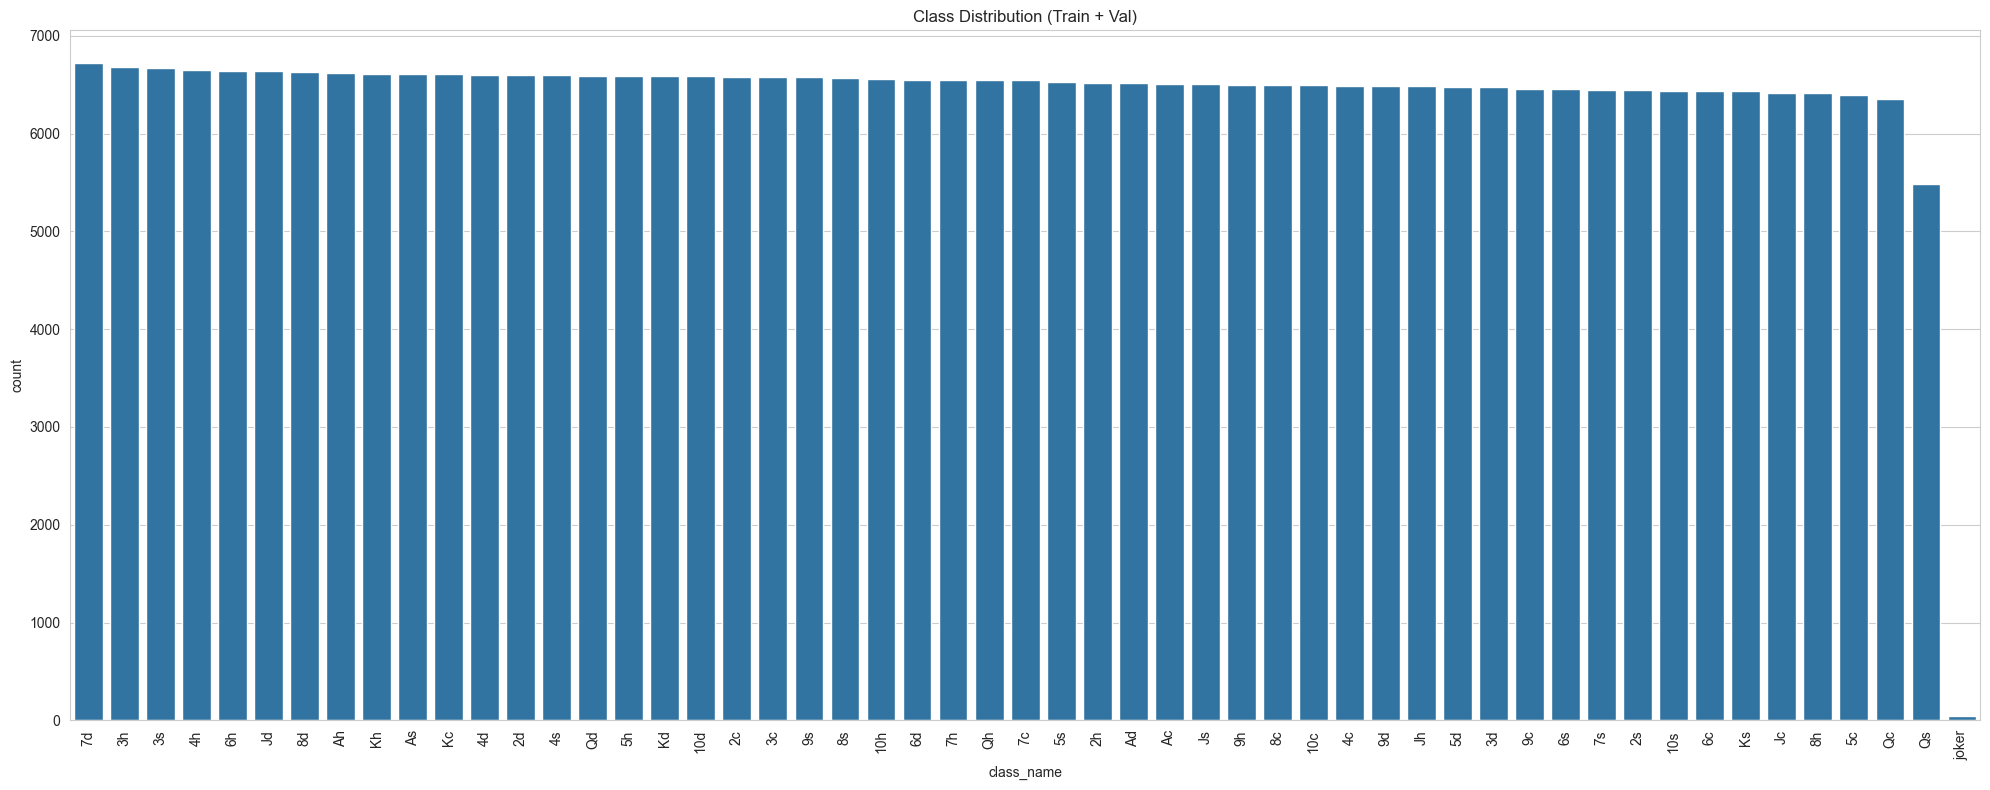

In [4]:
plt.figure(figsize=(20, 8))
sns.countplot(data=df[df['class_id'] != -1], x='class_name', order=df[df['class_id'] != -1]['class_name'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Class Distribution (Train + Val)")
plt.tight_layout()
plt.show()

## 4. Bounding Box Analysis

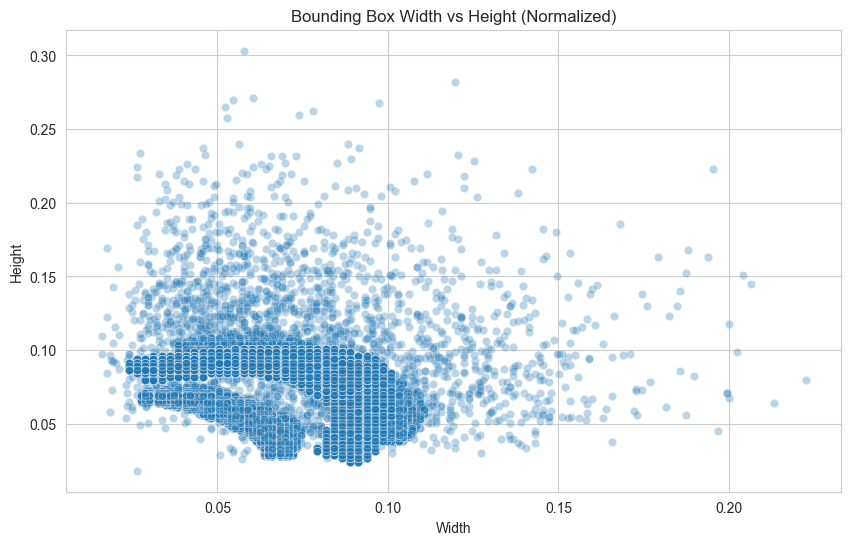

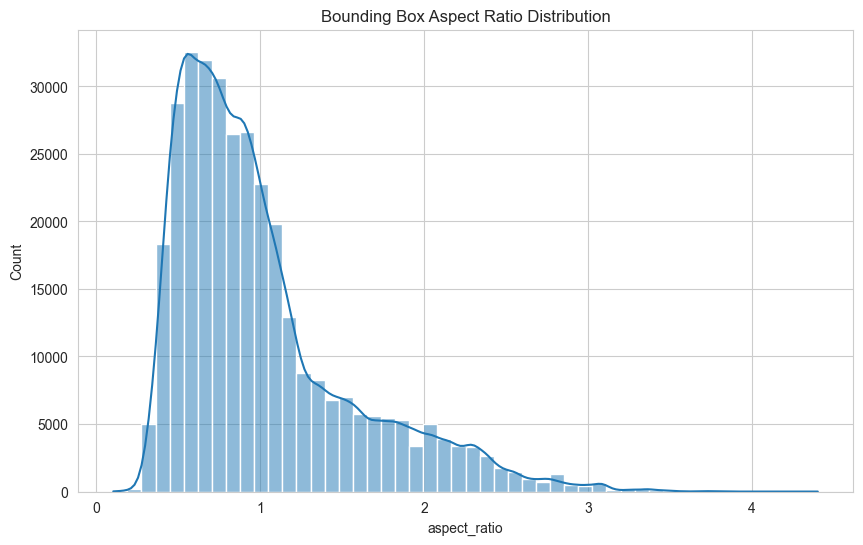

In [5]:
# Box Sizes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df[df['class_id'] != -1], x='width', y='height', alpha=0.3)
plt.title("Bounding Box Width vs Height (Normalized)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

# Aspect Ratio
df['aspect_ratio'] = df['width'] / df['height']
plt.figure(figsize=(10, 6))
sns.histplot(df[df['class_id'] != -1]['aspect_ratio'], bins=50, kde=True)
plt.title("Bounding Box Aspect Ratio Distribution")
plt.show()

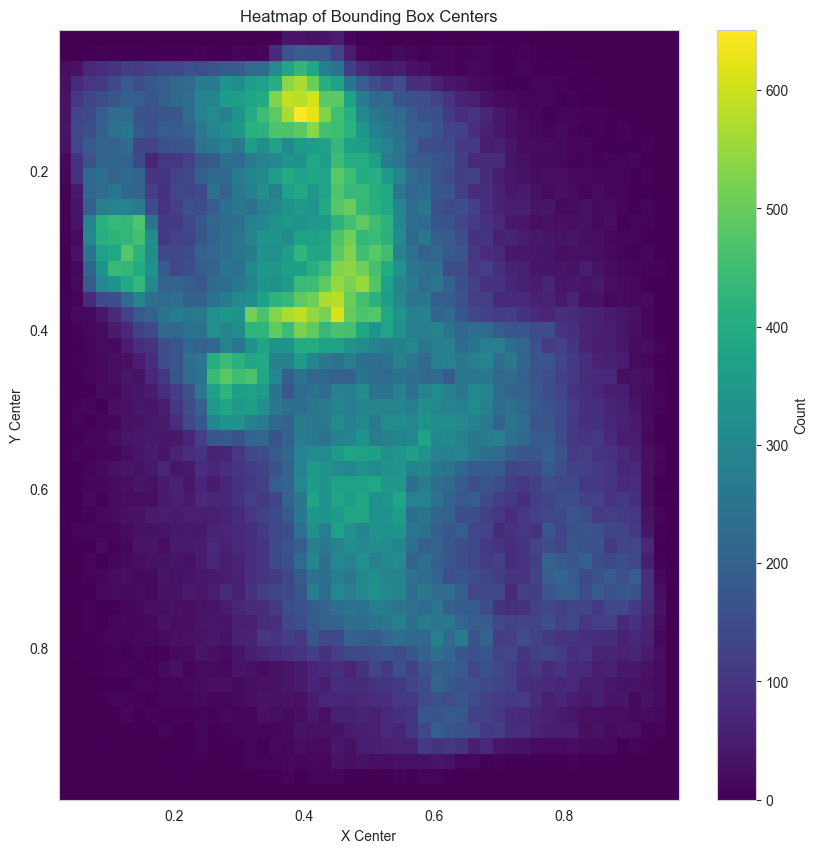

In [6]:
# Box Centers Heatmap
plt.figure(figsize=(10, 10))
plt.hist2d(df[df['class_id'] != -1]['x_center'], df[df['class_id'] != -1]['y_center'], bins=50, cmap='viridis')
plt.colorbar(label='Count')
plt.title("Heatmap of Bounding Box Centers")
plt.xlabel("X Center")
plt.ylabel("Y Center")
plt.gca().invert_yaxis() # Image coordinates: Y increases downwards
plt.show()

## 5. Image Content Analysis
Analyzing image resolutions and pixel intensities.

Analyzing Images: 100%|██████████| 500/500 [00:02<00:00, 168.17it/s]


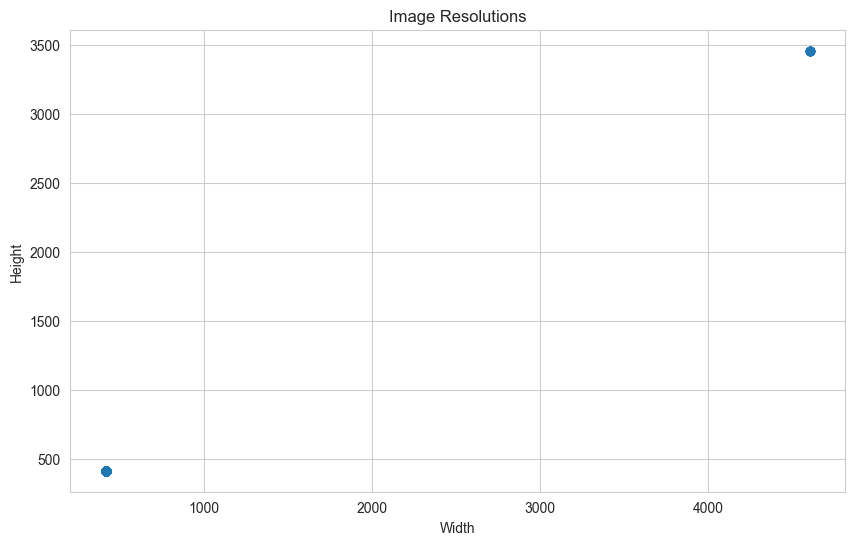

Average Resolution: [550.144 513.28 ]
Average Pixel Intensity (BGR): [108.97948914 115.35815293 125.98598335]


In [7]:
resolutions = []
pixel_means = []

# Sample a subset for speed if dataset is huge
sample_images = df['image_path'].unique()
if len(sample_images) > 500:
    sample_images = np.random.choice(sample_images, 500, replace=False)

for img_path in tqdm(sample_images, desc="Analyzing Images"):
    img = cv2.imread(img_path)
    if img is not None:
        h, w, c = img.shape
        resolutions.append((w, h))
        pixel_means.append(np.mean(img, axis=(0, 1)))

resolutions = np.array(resolutions)
pixel_means = np.array(pixel_means)

plt.figure(figsize=(10, 6))
plt.scatter(resolutions[:, 0], resolutions[:, 1], alpha=0.5)
plt.title("Image Resolutions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

print(f"Average Resolution: {np.mean(resolutions, axis=0)}")
print(f"Average Pixel Intensity (BGR): {np.mean(pixel_means, axis=0)}")

## 6. Visual Inspection

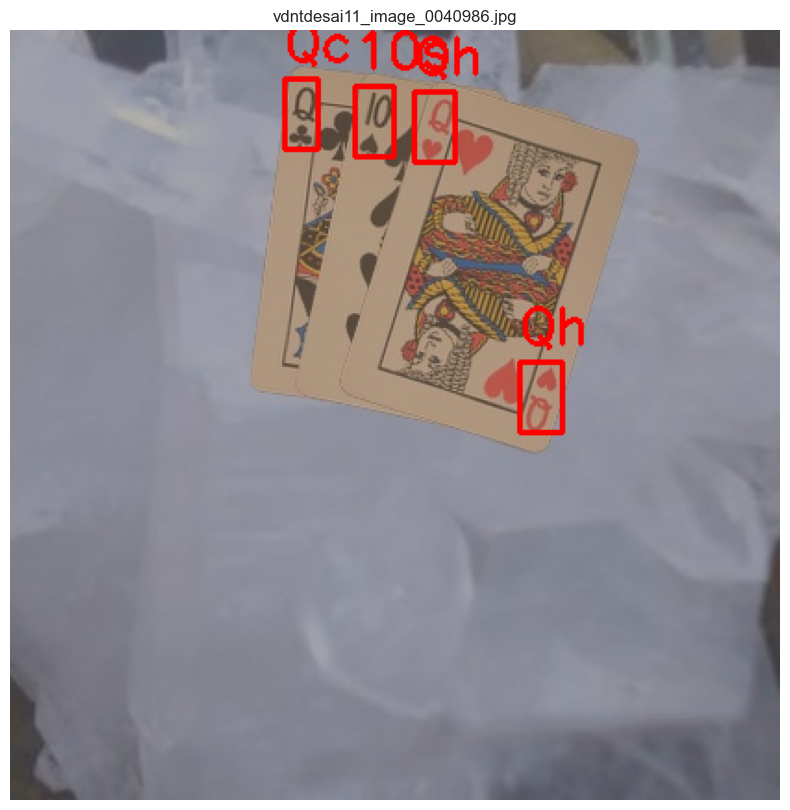

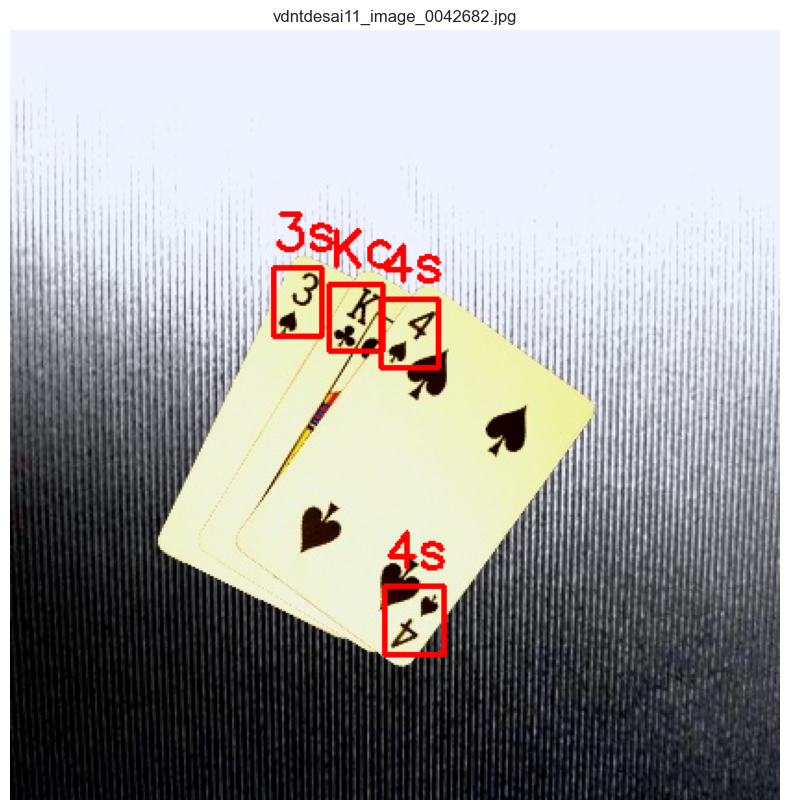

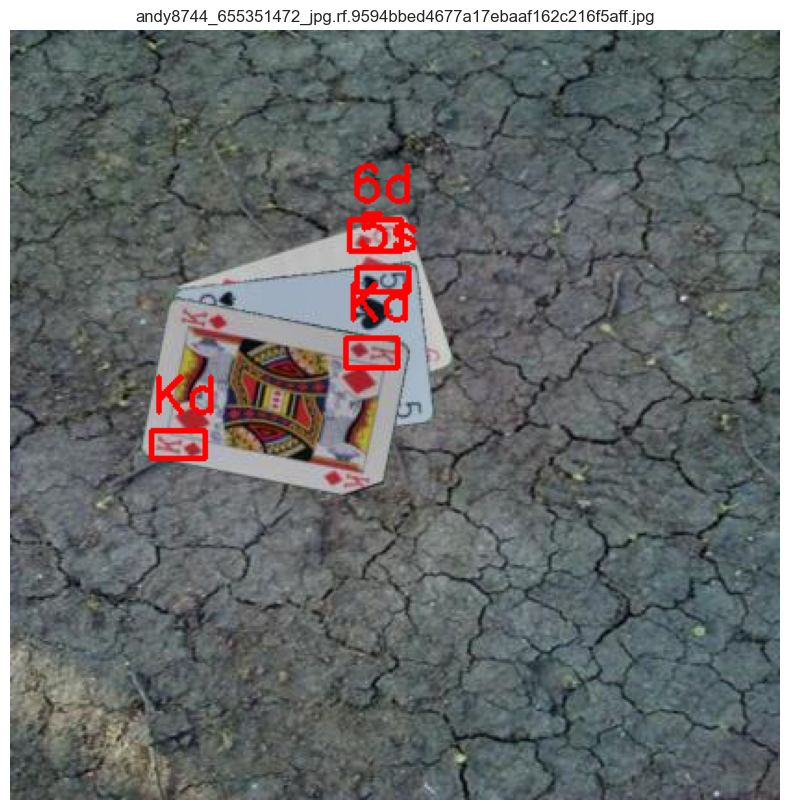

In [9]:
def plot_sample(image_path, df_labels):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    
    # Get labels for this image
    labels = df_labels[df_labels['image_path'] == image_path]
    
    for _, row in labels.iterrows():
        if row['class_id'] == -1: continue
        
        # Convert normalized xywh to pixel xyxy
        x_c, y_c, bw, bh = row['x_center'], row['y_center'], row['width'], row['height']
        x1 = int((x_c - bw/2) * w)
        y1 = int((y_c - bh/2) * h)
        x2 = int((x_c + bw/2) * w)
        y2 = int((y_c + bh/2) * h)
        
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, row['class_name'], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

# Show 3 random samples
unique_imgs = df['image_path'].unique()
random_samples = np.random.choice(unique_imgs, 3, replace=False)

for img_p in random_samples:
    plot_sample(img_p, df)